# Sujet M1 Maths Augmentation donnees 2024-2025

## Préparation des données, de l'encodage

### Import des packages

In [1]:
import sklearn.cross_decomposition as skdec
import sklearn.metrics as skmet
import pandas as pd
import numpy as np
import scipy.stats as scsts
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

#### MODIFICATIONS POSSIBLES 1 : 

Vous pouvez apporter des modifications a votre Training set.

### Chargement de la donnée

In [2]:
def load_data(path="Dataset_Reetz.csv"):
  dataset_df = pd.read_csv(path, sep=";")
  return dataset_df

SEQUENCE_KEY: str = "seq"
ACTIVITY_KEY: str = "act"
WHICH_SET_KEY: str = "set"
IS_TRAIN_SET_KEY: str = "TRAIN"


DATASET_DF = load_data()
DATASET_DF.head()

,id,mut,seq,act,set
0,WT,wt,NHKAFAKFPSSASISPNPFTVSIPDEQLDDLKTLVRLSKIAPPTYE...,-0.85,TRAIN
1,S1,L215F,NHKAFAKFPSSASISPNPFTVSIPDEQLDDLKTLVRLSKIAPPTYE...,-1.50,TRAIN
2,S2,A217N,NHKAFAKFPSSASISPNPFTVSIPDEQLDDLKTLVRLSKIAPPTYE...,-1.17,TRAIN
3,S3,R219S,NHKAFAKFPSSASISPNPFTVSIPDEQLDDLKTLVRLSKIAPPTYE...,-0.85,TRAIN
4,F,L249Y,NHKAFAKFPSSASISPNPFTVSIPDEQLDDLKTLVRLSKIAPPTYE...,-0.85,TRAIN


### Definition de l'encodage (Cid et al. 1992 Hydrophobicity)

On écrit un dictionnaire qui va nous servir à encoder la séquence de manière numérique.

In [3]:
AA_CID920101_ENCODING = {
  'A': -0.45,
  'R': -0.24,
  'N': -0.2,
  'D': -1.52,
  'C': 0.79,
  'Q': -0.99,
  'E': -0.8,
  'G': -1.0,
  'H': 1.07,
  'I': 0.76,
  'L': 1.29,
  'K': -0.36,
  'M': 1.37,
  'F': 1.48,
  'P': -0.12,
  'S': -0.98,
  'T': -0.7,
  'W': 1.38,
  'Y': 1.49,
  'V': 1.26
}

### Fonction pour encoder une sequence

In [4]:
def encode_sequence(sequence, mapping=AA_CID920101_ENCODING):
  return np.asarray([mapping[aa] for aa in sequence])

### Extraction des sequences, de l'activite et de leur appartenance au Training set ou au Test set

In [5]:
SEQUENCES = DATASET_DF[SEQUENCE_KEY]
ACTIVITY = DATASET_DF[ACTIVITY_KEY]
IS_TRAIN = DATASET_DF[WHICH_SET_KEY] == IS_TRAIN_SET_KEY

### Application de la fonction d'encodage et construction de la matice de travail

On encode le tableau de données en y extrayant une matrice numérique Numpy, avec l'encodage écrit ce dessus.

In [6]:
ENCODED_SEQUENCES = np.stack(SEQUENCES.apply(encode_sequence).values)
ENCODED_SEQUENCES

array([[-0.2 ,  1.07, -0.36, ...,  1.38, -0.99, -0.36],
       [-0.2 ,  1.07, -0.36, ...,  1.38, -0.99, -0.36],
       [-0.2 ,  1.07, -0.36, ...,  1.38, -0.99, -0.36],
       ...,
       [-0.2 ,  1.07, -0.36, ...,  1.38, -0.99, -0.36],
       [-0.2 ,  1.07, -0.36, ...,  1.38, -0.99, -0.36],
       [-0.2 ,  1.07, -0.36, ...,  1.38, -0.99, -0.36]])

### Separation des Training set et Test Set

On sépare la matrice en plusieurs sous matrices : 
- les $X$ correspondent aux caractéristiques de la séquence, c'est à dire les données sur lesquels le modèle va s'entraîner. Ici elles correspondent aux séquences protéiques encodées.
- les $Y$ correspondent aux étiquettes de la séquence, c'est à dire les valeurs cibles que le modèle doit prédire. Ici il s'agit des valeurs d'activité de la séquence protéique.
- les matrices stockées sous la terminaison _train serviront à entraîner le modèle, tandis que les données sous la terminaison _test serviront à tester le modèle et observer son efficacité.


In [7]:
X_TRAIN = ENCODED_SEQUENCES[IS_TRAIN]
Y_TRAIN = ACTIVITY[IS_TRAIN].values
X_TEST = ENCODED_SEQUENCES[~IS_TRAIN]
Y_TEST = ACTIVITY[~IS_TRAIN].values

#### MODIFICATIONS POSSIBLES 2 : Vous  pouvez appliquer des transformations mathematiques a votre Training set.

## Definition et entrainement du modele PLS

modèle choisi : régression PLS (Partial LEast Squares) utile lorsque les variables prédictrices sont fortement corrélées/ que le nombre de variables prédictrices est supérieur au nombre d'observations.

l'objectif est de trouver une relation linéaire entre $X$ et $Y$ en projetant les variables dans un nouvel espace de dimension réduite.      
On pose $X=TP^T + E$, $Y=UQ^T+F$ avec $T,U$ les projections des données dans un nouvel espace, $P,Q$ les poids des variables dans le nouvel espace, et $E,F$ les résidus.    



In [8]:
MODEL = skdec.PLSRegression()
MODEL.fit(X_TRAIN, Y_TRAIN)

PLSRegression()

### Evaluation du modèle (Calcul des metriques de performance)

- la corrélation de Pearson mesure la relation linéaire entre les valeurs prédites et les valeurs réelles : $r=\frac{\sum(x_i-\bar x)(y_i- \bar y)}{\sqrt{\sum (x_i - \bar x)^2 \sum ( y_i - \bar y)^2}}$. Si elle est proche de $1$ ou $-1$, alors elle indique une forte corrélation linéaire. 
- le coefficient de détermination $R^2$ est une mesure de proportion de la variance des valeurs réelles expliquée par le modèle : $R^2 = 1 - \frac{\sum (y_i- \hat{y_i})^2}{\sum(y_i- \bar y )^2}$. Elle indique à quel point les prédictions du modèle sont proches des valeurs réelles. Si elle est proche de $1$, alors elle explique bien la valeur des donnnées.
- L'erreur quadratique RMSE mesure l'écart moyen entre les valeurs prédites et les valeurs réelles : $\text{RMSE}= \sqrt{\frac 1n \sum(y_i- \hat{y_i})^2}$. Elle pénalise fortement les grandes erreurs

In [9]:
def evaluate_model(trained_model, x_test, y_test):
  predictions = trained_model.predict(x_test)
  correlation, _ = scsts.pearsonr(y_test, predictions)
  r2 = skmet.r2_score(y_test, predictions)
  rmse = skmet.root_mean_squared_error(y_test, predictions)
  data = {"Correlation": [correlation], "R2": [r2], "RMSE": [rmse]}
  return pd.DataFrame(data)

evaluate_model(MODEL, X_TEST, Y_TEST)

,Correlation,R2,RMSE
0,0.923426,0.592855,0.576412


le coefficient de corrélation est proche de 1, en revanche le coefficient de détermination n'est que relativement proche de 1, ce qui signifie qu'il est souhaitable de chercher un modèle qui prédit mieux les valeurs, dans la mesure du possible.

On ajoute deux retours à la fonction qui évalue le modèle : 

- L'erreur absolue moyenne MAE mesure l'écart moyen absolu entre les valeurs prédites et les valeurs réelles : $\text{MAE}=\frac 1n \sum |y_i - \hat{y_i}|$. Il évalue l'exactitude des prédictions du modèle.
- L'erreur absolue moyenne en pourcentage MAPE mesure l'écart moyen absolu en pourcentage entre les valeurs prédites et les valeurs réelles : $\text{MAPE}= \frac 1n  \sum \Big| \frac{y_i- \hat{y_i}}{y_i} \Big|  \times 100$

In [10]:
def evaluate_model_v2(trained_model, x_test, y_test):
    predictions = trained_model.predict(x_test)
    correlation, _ = scsts.pearsonr(y_test, predictions)
    r2 = skmet.r2_score(y_test, predictions)
    rmse = skmet.root_mean_squared_error(y_test, predictions)
    mae = skmet.mean_absolute_error(y_test, predictions)
    mape = skmet.mean_absolute_percentage_error(y_test, predictions)
    data = {
        "Correlation": [correlation],
        "R2": [r2],
        "RMSE": [rmse],
        "MAE": [mae],
        "MAPE": [mape]
    }
    return pd.DataFrame(data)

evaluate_model_v2(MODEL, X_TEST, Y_TEST)

,Correlation,R2,RMSE,MAE,MAPE
0,0.923426,0.592855,0.576412,0.478348,0.215639


les erreurs absolues sont proches de 0, donc le modèle a une bonne précision.

### Affichage des prédictions: visualisation des plots

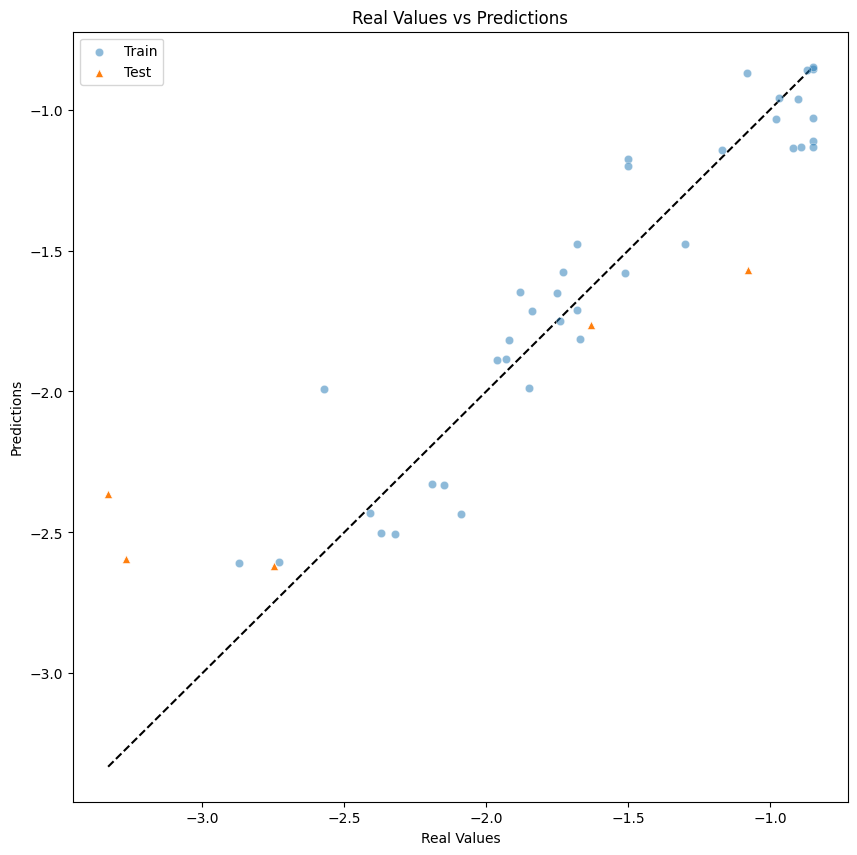

In [11]:
PALETTE = sns.color_palette("tab10")
TRAIN_COLOR = PALETTE[0]
TEST_COLOR = PALETTE[1]

def plot_regression(predictions, real_values, label, color, marker, alpha=0.5, ax=None):
  if ax is None:
    _, ax = plt.subplots(1, 1, figsize=(10, 10))
  sns.scatterplot(x=real_values, y=predictions, color=color, label=label, alpha=alpha, marker=marker, ax=ax)
  ax.set_xlabel("Real Values")
  ax.set_ylabel("Predictions")
  ax.set_title("Real Values vs Predictions")

TRAIN_PREDS = MODEL.predict(X_TRAIN)
TEST_PREDS = MODEL.predict(X_TEST)

FIG, AX = plt.subplots(1, 1, figsize=(10, 10))
MIN_X = min(Y_TRAIN.min(), Y_TEST.min())
MAX_X = max(Y_TRAIN.max(), Y_TEST.max())
sns.lineplot(x=[MIN_X, MAX_X],
               y=[MIN_X, MAX_X],
               ax=AX, color="black", linestyle="--", zorder=-1)
plot_regression(TRAIN_PREDS, Y_TRAIN, "Train", TRAIN_COLOR, "o", ax=AX)
plot_regression(TEST_PREDS, Y_TEST, "Test", TEST_COLOR, "^", alpha=1, ax=AX)

Le modèle a l'air globalement efficace, on peut le retenir

## Tests sur d'autres modèles

On teste d'autres modèles de Régression linéaire pour voir si elles donnent de meilleurs résultats.

### Modèle Régréssion linéaire : Définition et Entraînement

Elle modélise la relation mlinéaire entre la variable $Y$ et les variables $X$.       
Le modèle est défini comme suit : $Y=\beta_0 + \sum_{i=1} \beta_i X_i + \varepsilon$. Les coefficients sont estimés par la méthode des mpindres carrés.

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
model_RL = LinearRegression()
model_RL.fit(X_TRAIN,Y_TRAIN)

LinearRegression()

#### Evaluation du modèle

In [14]:
evaluate_model(model_RL,X_TEST,Y_TEST)

,Correlation,R2,RMSE
0,0.914782,0.714677,0.482533


le coefficient de corrélation est comparable au modèle précédent. Et son coefficient de détermination semble lui, nettement meilleur que le modèle précédent.

In [15]:
evaluate_model_v2(model_RL, X_TEST, Y_TEST)

,Correlation,R2,RMSE,MAE,MAPE
0,0.914782,0.714677,0.482533,0.405215,0.178088


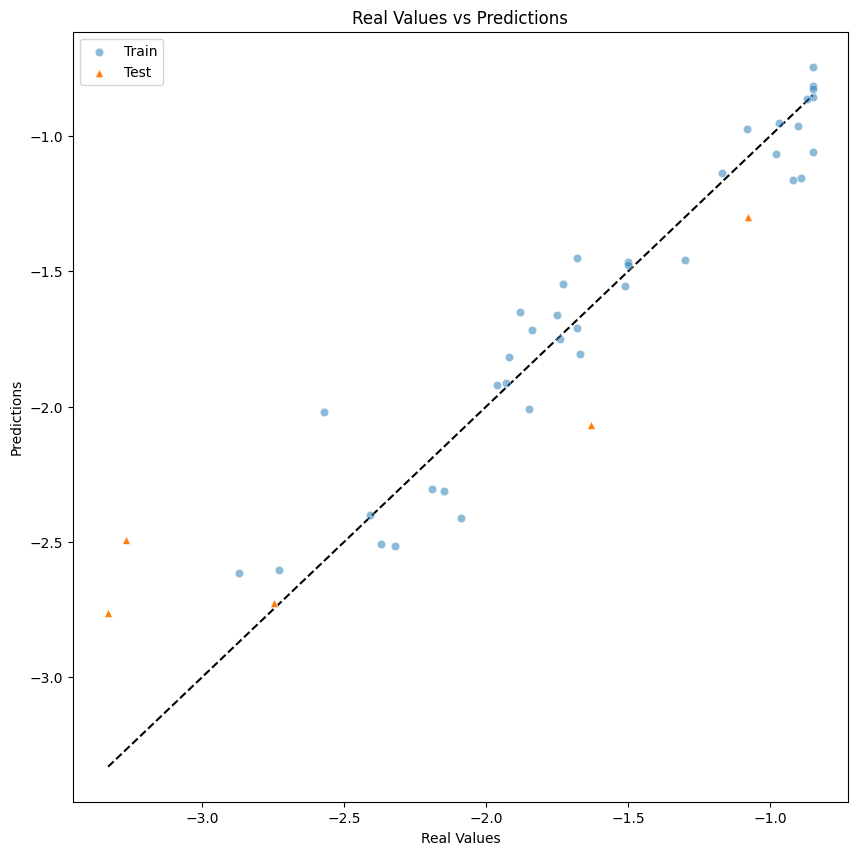

In [16]:
TRAIN_PREDS = model_RL.predict(X_TRAIN)
TEST_PREDS = model_RL.predict(X_TEST)

FIG, AX = plt.subplots(1, 1, figsize=(10, 10))
MIN_X = min(Y_TRAIN.min(), Y_TEST.min())
MAX_X = max(Y_TRAIN.max(), Y_TEST.max())
sns.lineplot(x=[MIN_X, MAX_X],
               y=[MIN_X, MAX_X],
               ax=AX, color="black", linestyle="--", zorder=-1)

plot_regression(TRAIN_PREDS, Y_TRAIN, "Train", TRAIN_COLOR, "o", ax=AX)
plot_regression(TEST_PREDS, Y_TEST, "Test", TEST_COLOR, "^", alpha=1, ax=AX)

On observe que le modèle rend des résultats similaires au modèle PLS. Et même un peu plus précises.

### Modèle Régression Ridge : Définition et entraînement

Il réduit la variance des coefficients de régression en ajoutant une pénalité de régularisation.      
Le modèle est défini comme suit : $Y=\beta_0 + \sum_{i=1} \beta_i X_i + \varepsilon$. Les coefficients sont estimésen minimisant $\sum_{i=1} ( Y_i - \hat{Y_i})^2 + \lambda \sum_{j=1} \beta_j^2$

In [17]:
from sklearn.linear_model import Ridge

In [18]:
model_Ridge = Ridge(alpha=1.0)
model_Ridge.fit(X_TRAIN,Y_TRAIN)

Ridge()

#### Evaluation du modèle

In [19]:
evaluate_model(model_Ridge, X_TEST, Y_TEST)

,Correlation,R2,RMSE
0,0.731499,0.248082,0.783328


le coefficient de corrélation semble en nette baisse par rapport aux modèles linéaires et PLS précédents, et le coefficient de détermination est lui assez faible, ce qui indique une mauvaise précision du modèle.

In [20]:
evaluate_model_v2(model_Ridge, X_TEST, Y_TEST)

,Correlation,R2,RMSE,MAE,MAPE
0,0.731499,0.248082,0.783328,0.655653,0.284912


On voit que les erreurs absolues sont un peu plus élevées que les modèles précédents.

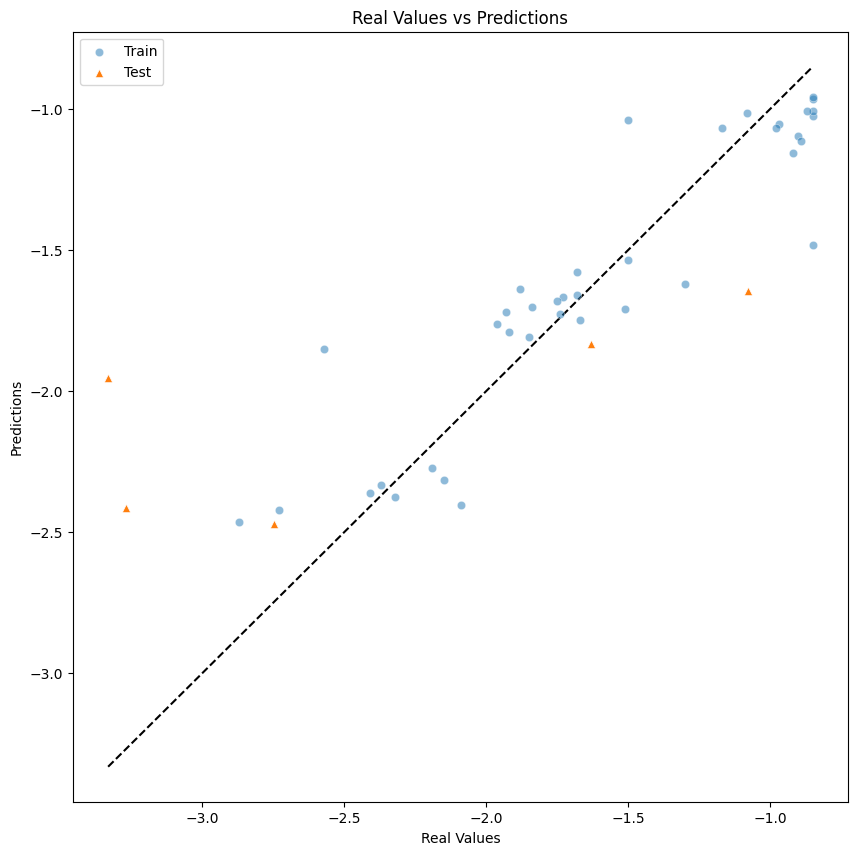

In [21]:
TRAIN_PREDS = model_Ridge.predict(X_TRAIN)
TEST_PREDS = model_Ridge.predict(X_TEST)

FIG, AX = plt.subplots(1, 1, figsize=(10, 10))
MIN_X = min(Y_TRAIN.min(), Y_TEST.min())
MAX_X = max(Y_TRAIN.max(), Y_TEST.max())
sns.lineplot(x=[MIN_X, MAX_X],
               y=[MIN_X, MAX_X],
               ax=AX, color="black", linestyle="--", zorder=-1)

plot_regression(TRAIN_PREDS, Y_TRAIN, "Train", TRAIN_COLOR, "o", ax=AX)
plot_regression(TEST_PREDS, Y_TEST, "Test", TEST_COLOR, "^", alpha=1, ax=AX)

On remarque que ce modèle Ridge est nettement moins performant que les deux précédents (PLS et Lineaire). Il est à mettre à l'écart pour l'instant.

### Modèle Régression Lasso : Définition et entraînement

Il permet de réduire la variance des coefficients de régression en ajoutant une pénalité de régularisation.     
Le modèle est défini comme suit : $Y=\beta_0 + \sum_{i=1} \beta_i X_i + \varepsilon$. Les coefficients sont estimés en minimisant $\sum_{i=1}(Y_i-\hat{Y_i})^2+\lambda \sum_{j=1}|\beta_j|$

In [22]:
from sklearn.linear_model import Lasso

In [23]:
model_L = Lasso(alpha=0.1)
model_L.fit(X_TRAIN, Y_TRAIN)

Lasso(alpha=0.1)

On a au fur et à mesur baissé le coefficient $\alpha$ étant donné les résultats insatisfaisantes.

#### Evaluation du modèle

In [24]:
evaluate_model(model_L, X_TEST, Y_TEST)

,Correlation,R2,RMSE
0,0.728604,-0.160207,0.97303


Malgré tout, le coefficient de corrélation est comparable au modèle précédent (Ridge) et le coefficient de détermination est lui, trop faible.

In [25]:
evaluate_model_v2(model_L, X_TEST, Y_TEST)

,Correlation,R2,RMSE,MAE,MAPE
0,0.728604,-0.160207,0.97303,0.825934,0.326871


De même, les erreurs absolues calculées sont encore plus élevées.

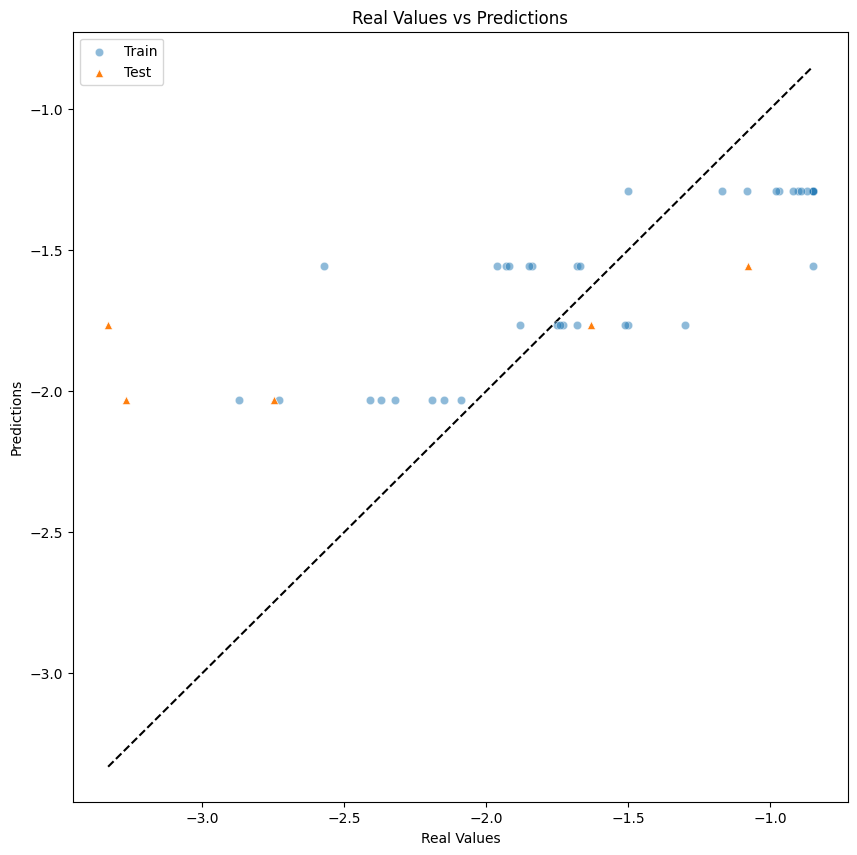

In [26]:
TRAIN_PREDS = model_L.predict(X_TRAIN)
TEST_PREDS = model_L.predict(X_TEST)

FIG, AX = plt.subplots(1, 1, figsize=(10, 10))
MIN_X = min(Y_TRAIN.min(), Y_TEST.min())
MAX_X = max(Y_TRAIN.max(), Y_TEST.max())
sns.lineplot(x=[MIN_X, MAX_X],
               y=[MIN_X, MAX_X],
               ax=AX, color="black", linestyle="--", zorder=-1)

plot_regression(TRAIN_PREDS, Y_TRAIN, "Train", TRAIN_COLOR, "o", ax=AX)
plot_regression(TEST_PREDS, Y_TEST, "Test", TEST_COLOR, "^", alpha=1, ax=AX)

Le modèle n'est pas du tout fiable, et visiblement, annule trop de coefficients en cours de route et donc n'est pas prédictif.Il n'est pas adapté à notre jeu de données.

### Modèle de régression avec forêts aléatoires : Définition et entraînement

Il combine plusieurs arbres de décisions pour améliorer la précision du modèle.      
Il fonctionne avec un ensemble de $N$ arbres de décisions, et la prédiction  est réalisée de la sorte : $\hat Y= \frac 1N \sum_{i=1} T_i (N)$

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
model_random = RandomForestRegressor(n_estimators=100, random_state=42)
model_random.fit(X_TRAIN,Y_TRAIN)

RandomForestRegressor(random_state=42)

#### Evaluation du modèle

In [29]:
evaluate_model(model_random, X_TEST, Y_TEST)

,Correlation,R2,RMSE
0,0.926867,0.674157,0.515659


On observe que le coefficient de corrélation redevient aussi élevé que les modèles PLS et Linear, et le coefficient de détermination un peu moins bien que le modèle Linear, mais meilleur que le modèle PLS.

In [30]:
evaluate_model_v2(model_random, X_TEST, Y_TEST)

,Correlation,R2,RMSE,MAE,MAPE
0,0.926867,0.674157,0.515659,0.427727,0.202215


Idem les erreurs absolues calculées sont similaires au modèles PLS et Linar.

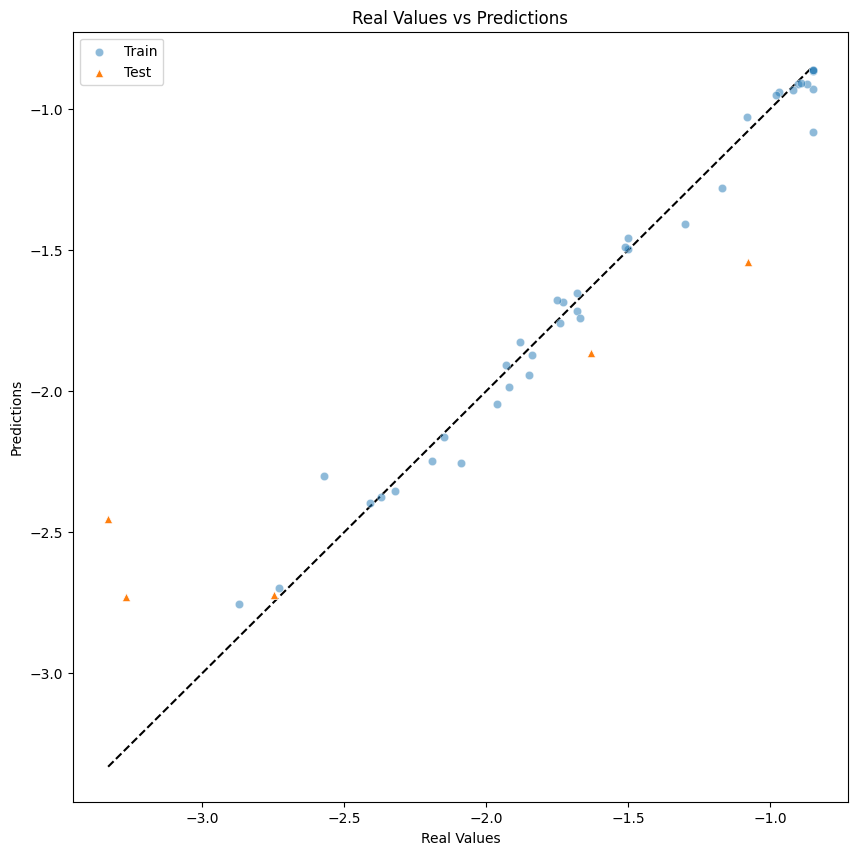

In [31]:
TRAIN_PREDS = model_random.predict(X_TRAIN)
TEST_PREDS = model_random.predict(X_TEST)

FIG, AX = plt.subplots(1, 1, figsize=(10, 10))
MIN_X = min(Y_TRAIN.min(), Y_TEST.min())
MAX_X = max(Y_TRAIN.max(), Y_TEST.max())
sns.lineplot(x=[MIN_X, MAX_X],
               y=[MIN_X, MAX_X],
               ax=AX, color="black", linestyle="--", zorder=-1)

plot_regression(TRAIN_PREDS, Y_TRAIN, "Train", TRAIN_COLOR, "o", ax=AX)
plot_regression(TEST_PREDS, Y_TEST, "Test", TEST_COLOR, "^", alpha=1, ax=AX)

Il a visiblement des résultats comparables aux modèle PLS et Linéaire.

### Régression avec machines à vecteurs de support : Définition et apprentissage

L'idée est de trouver une fonction de décision qui maximise la marge entre les classes.
le modèle est schématisé comme suit : $T=\omega • \phi(X)+b$, $\phi$ est la fonction qui transforme la variable d'entrée et les coefficients $\omega,b$ sont estimés en minimisant $\frac 12 \| \omega \| ^2 + C \sum_{i=1} \xi_i$

In [32]:
from sklearn.svm import SVR

In [33]:
model_svr = SVR(kernel='rbf')
model_svr.fit(X_TRAIN,Y_TRAIN)

SVR()

#### Evaluation du modèle

In [34]:
evaluate_model(model_svr, X_TEST, Y_TEST)

,Correlation,R2,RMSE
0,0.936001,-0.357468,1.052503


on voit que le coefficient de corréltion est comparable aux modèles PLS, Linear mais que le coefficient de détermination est trop faible, semblable au modèle Lasso.

In [35]:
evaluate_model_v2(model_svr, X_TEST, Y_TEST)

,Correlation,R2,RMSE,MAE,MAPE
0,0.936001,-0.357468,1.052503,0.887715,0.344542


l'erreur absolue aussi est semblable au modèle Lasso.

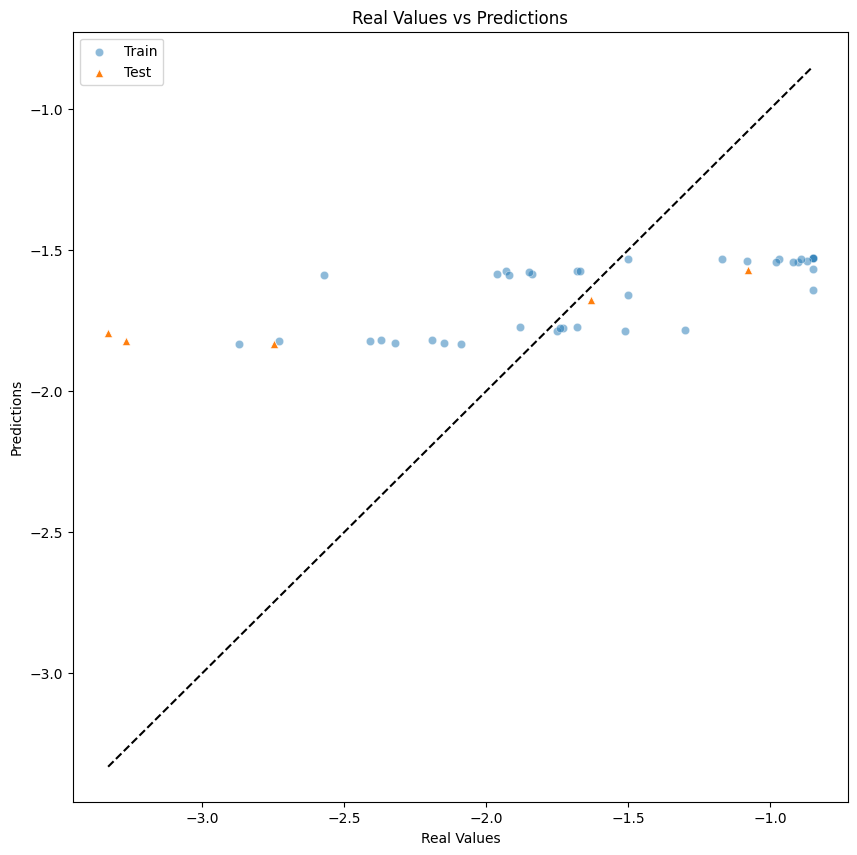

In [36]:
TRAIN_PREDS = model_svr.predict(X_TRAIN)
TEST_PREDS = model_svr.predict(X_TEST)

FIG, AX = plt.subplots(1, 1, figsize=(10, 10))
MIN_X = min(Y_TRAIN.min(), Y_TEST.min())
MAX_X = max(Y_TRAIN.max(), Y_TEST.max())
sns.lineplot(x=[MIN_X, MAX_X],
               y=[MIN_X, MAX_X],
               ax=AX, color="black", linestyle="--", zorder=-1)

plot_regression(TRAIN_PREDS, Y_TRAIN, "Train", TRAIN_COLOR, "o", ax=AX)
plot_regression(TEST_PREDS, Y_TEST, "Test", TEST_COLOR, "^", alpha=1, ax=AX)

Il n'est visiblement pas fiable non plus. On peut l'écarter.

## Modèles retenus : PLS, Linéaires, Random Forest

On va se concentrer sur ces modèles de Régression, et chercher les meilleurs paramètres en utilisant la validation croisée.      
On va garder nos matrices de travail.

In [39]:
X_TRAIN.shape, X_TEST.shape, Y_TRAIN.shape, Y_TEST.shape

((38, 398), (5, 398), (38,), (5,))

#### package pour faire de la validation croisée : 

In [40]:
from sklearn.model_selection import GridSearchCV

### Modèle PLS (Partial Least Squares)

#### Recherche des paramètres optimaux 
On commence par stocker les paramètres à tester :

In [41]:
param_grid_PLS={
    'n_components':[1, 2, 3, 4, 5]
}

On cherche ensuite les meilleurs paramètres :

In [42]:
grid_search_PLS = GridSearchCV(estimator=MODEL, param_grid=param_grid_PLS,
                               cv=5, scoring='neg_mean_squared_error')
grid_search_PLS.fit(X_TRAIN, Y_TRAIN)

GridSearchCV(cv=5, estimator=PLSRegression(),
             param_grid={'n_components': [1, 2, 3, 4, 5]},
             scoring='neg_mean_squared_error')

In [43]:
print("Meilleurs paramètres pour le modèle PLS :", grid_search_PLS.best_params_)

Meilleurs paramètres pour le modèle PLS : {'n_components': 3}


#### Nouveau test du modèle avec les paramètres optimaux
On refait la même procédure que précedemment avec les nouveaux paramètres

In [46]:
model_PLS=skdec.PLSRegression(n_components=3)
model_PLS.fit(X_TRAIN, Y_TRAIN)

PLSRegression(n_components=3)

In [47]:
evaluate_model(model_PLS, X_TEST, Y_TEST)

,Correlation,R2,RMSE
0,0.943792,0.662491,0.524809


In [48]:
evaluate_model_v2(model_PLS, X_TEST, Y_TEST)

,Correlation,R2,RMSE,MAE,MAPE
0,0.943792,0.662491,0.524809,0.456369,0.215728


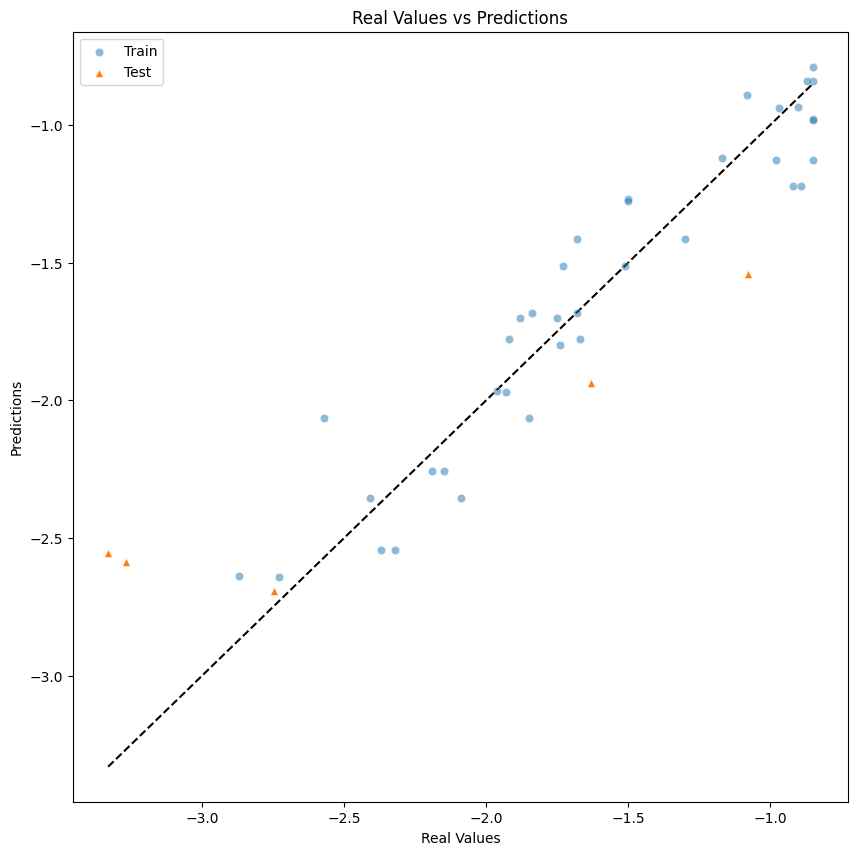

In [49]:
PALETTE = sns.color_palette("tab10")
TRAIN_COLOR = PALETTE[0]
TEST_COLOR = PALETTE[1]

TRAIN_PREDS = model_PLS.predict(X_TRAIN)
TEST_PREDS = model_PLS.predict(X_TEST)

FIG, AX = plt.subplots(1, 1, figsize=(10, 10))
MIN_X = min(Y_TRAIN.min(), Y_TEST.min())
MAX_X = max(Y_TRAIN.max(), Y_TEST.max())
sns.lineplot(x=[MIN_X, MAX_X],
               y=[MIN_X, MAX_X],
               ax=AX, color="black", linestyle="--", zorder=-1)
plot_regression(TRAIN_PREDS, Y_TRAIN, "Train", TRAIN_COLOR, "o", ax=AX)
plot_regression(TEST_PREDS, Y_TEST, "Test", TEST_COLOR, "^", alpha=1, ax=AX)

### Modèle de Régression Linéaire (LinearRegression)

#### Recherche des paramètres optimaux

In [54]:
param_grid_RL = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

In [55]:
grid_search_RL = GridSearchCV(estimator=model_RL, param_grid=param_grid_RL, 
                              cv=5, scoring='neg_mean_squared_error')
grid_search_RL.fit(X_TRAIN, Y_TRAIN)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'positive': [True, False]},
             scoring='neg_mean_squared_error')

In [56]:
print("Meilleurs paramètres pour le modèle PLS :", grid_search_RL.best_params_)

Meilleurs paramètres pour le modèle PLS : {'fit_intercept': True, 'positive': False}


C'est les paramètres par défaut. Le modèle ne peut pas être meilleur visiblement.

### Modèle Random Forest (Forêts Aléatoires)

#### Recherche des paramètres optimaux

In [57]:
param_grid_random = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [59]:
grid_search_random = GridSearchCV(estimator=model_random, param_grid=param_grid_random, cv=5, scoring='neg_mean_squared_error')
grid_search_random.fit(X_TRAIN, Y_TRAIN)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [60]:
print("Meilleurs paramètres pour Random Forest :", grid_search_random.best_params_)

Meilleurs paramètres pour Random Forest : {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Il nous indique d'augmenter le nombre d'estimateurs à 300, et le reste des paramètres recommandé sont les paramètres par défaut.

#### Nouveau test du modèle 

In [63]:
model_random = RandomForestRegressor(n_estimators=300, random_state=42)
model_random.fit(X_TRAIN, Y_TRAIN)

RandomForestRegressor(n_estimators=300, random_state=42)

In [64]:
evaluate_model(model_random, X_TEST, Y_TEST)

,Correlation,R2,RMSE
0,0.918618,0.648571,0.535522


In [65]:
evaluate_model_v2(model_random, X_TEST, Y_TEST)

,Correlation,R2,RMSE,MAE,MAPE
0,0.918618,0.648571,0.535522,0.446007,0.21042


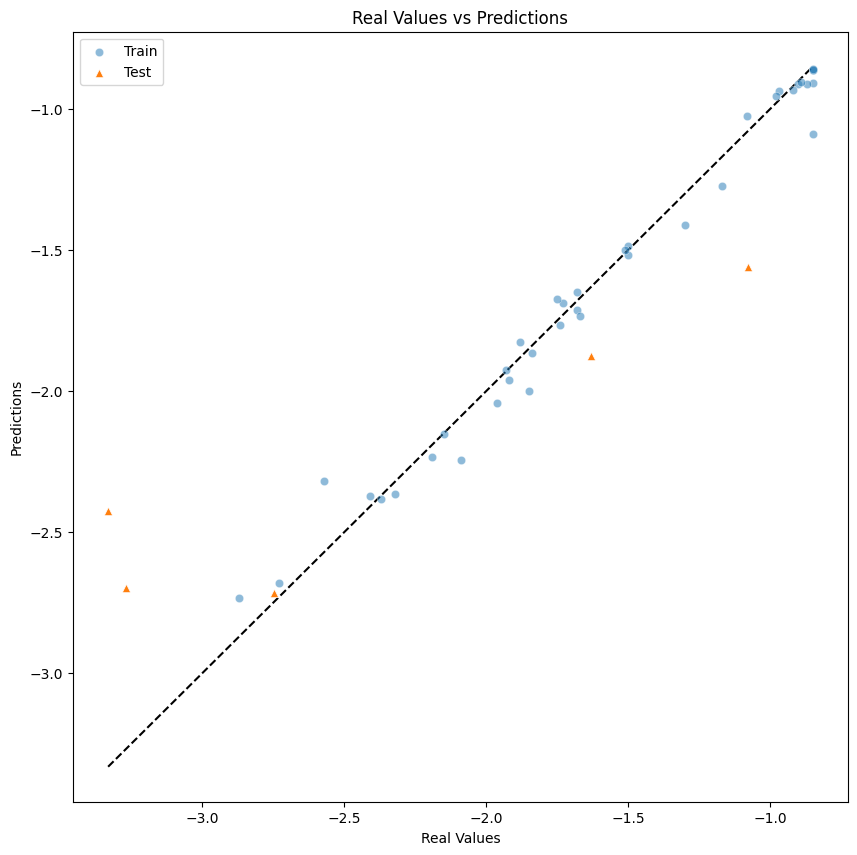

In [66]:
TRAIN_PREDS = model_random.predict(X_TRAIN)
TEST_PREDS = model_random.predict(X_TEST)

FIG, AX = plt.subplots(1, 1, figsize=(10, 10))
MIN_X = min(Y_TRAIN.min(), Y_TEST.min())
MAX_X = max(Y_TRAIN.max(), Y_TEST.max())
sns.lineplot(x=[MIN_X, MAX_X],
               y=[MIN_X, MAX_X],
               ax=AX, color="black", linestyle="--", zorder=-1)

plot_regression(TRAIN_PREDS, Y_TRAIN, "Train", TRAIN_COLOR, "o", ax=AX)
plot_regression(TEST_PREDS, Y_TEST, "Test", TEST_COLOR, "^", alpha=1, ax=AX)